In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
(train_image, train_lable), (test_image, test_label) = tf.keras.datasets.mnist.load_data()

In [3]:
train_image.shape

(60000, 28, 28)

In [4]:
train_image = train_image/255

In [5]:
train_image = train_image.reshape(60000, -1)

In [6]:
train_image = train_image.astype(np.float32)

In [7]:
train_image.shape

(60000, 784)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices(train_image)

In [9]:
dataset = dataset.shuffle(60000).batch(128)

In [10]:
class VAE_model(tf.keras.Model):
    def __init__(self):
        super(VAE_model, self).__init__()
        self.lin_1 = tf.keras.layers.Dense(400)
        self.lin_2 = tf.keras.layers.Dense(20)
        self.lin_3 = tf.keras.layers.Dense(20)
        self.lin_4 = tf.keras.layers.Dense(400)
        self.lin_5 = tf.keras.layers.Dense(784)
        
    def encode(self, x):
        h1 = tf.nn.relu(self.lin_1(x))
        return self.lin_2(h1), self.lin_3(h1)
    
    def reparameters(self, mu, logvar):
        std = tf.math.exp(0.5*logvar)
        eps = tf.random.normal(std.shape, mean=0.0, stddev=1.0)
        return mu + eps*std
        
    def decode(self, z):
        h4 = tf.nn.relu(self.lin_4(z))
        return tf.sigmoid(self.lin_5(h4))
    
    def call(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameters(mu, logvar)
        return self.decode(z), mu, logvar

In [11]:
def loss_function(recon_x, x, mu, logvar):
    BCE_loss = tf.keras.losses.binary_crossentropy(x, recon_x)
    KLD_loss = -0.5*tf.reduce_sum(1 + logvar 
                                  - tf.pow(mu, 2) 
                                  - tf.exp(logvar))
    return BCE_loss + 0.0001*KLD_loss

In [12]:
model = VAE_model()

In [13]:
opt = tf.keras.optimizers.Adam(0.0001)

In [14]:
epoch_loss_avg = tf.keras.metrics.Mean('train_loss')

In [15]:
def train_step(model, images):
    with tf.GradientTape() as t:
        pred_img, mu, logvar = model(images)
        loss_step = loss_function(pred_img, images, mu, logvar)
    grads = t.gradient(loss_step, model.trainable_variables)
    opt.apply_gradients(zip(grads, model.trainable_variables))
    epoch_loss_avg(loss_step)
    return pred_img

In [16]:
train_loss_results = []

In [17]:
num_epochs = 30

In [ ]:
# for epoch in range(num_epochs):
    for imgs in dataset:
        gen_imgs = train_step(model, imgs)
    print(epoch)
    
    train_loss_results.append(epoch_loss_avg.result())
    
    print('Epoch:{}: loss: {:.3f}'.format(
        epoch + 1,
        epoch_loss_avg.result()
    ))
    
    epoch_loss_avg.reset_states()
    
    for i in range(64):
        plt.subplot(8, 8, i+1)
        plt.imshow(gen_imgs[i].numpy().reshape(28, 28), cmap='gray')
        plt.xticks([])
        plt.yticks([])
        plt.axis('off')
    plt.show()

In [1]:
# 应用VAE

In [19]:
test_mu = np.linspace(-0.9, 0.9, 2000).reshape(100, 20).astype(np.float32)
test_logvar = np.linspace(0, 3, 2000).reshape(100, 20).astype(np.float32)

In [20]:
test_img = model.decode(model.reparameters(test_mu, test_logvar))

In [21]:
test_img.shape

TensorShape([100, 784])

In [22]:
test_img = test_img.numpy().reshape(-1, 28, 28)

In [23]:
test_img.shape

(100, 28, 28)

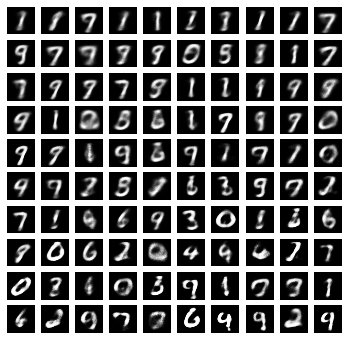

In [24]:
plt.figure(figsize=(6, 6))
for i in range(100):
    plt.subplot(10, 10, i+1)
    plt.imshow(test_img[i], cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')